In [12]:
import itertools
import re
from collections import Counter
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import string

# NLTK
import nltk
from nltk import wordpunct_tokenize
nltk.download('words')

from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import (
    pack_padded_sequence, pad_packed_sequence, pad_sequence,
)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')

tqdm.pandas()

# Show better CUDA error messages
!export CUDA_LAUNCH_BLOCKING=1

[nltk_data] Downloading package words to /home/jeffrey/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!aws s3 cp s3://sb-airflow/flattened-profiles/prod/2019-06-27_@v0.7.10_flattened_profiles_full.jsonl data/flattened_profiles_full.jsonl


In [2]:
deepsee_profiles = 'data/flattened_profiles_full.jsonl'
deepsee_df = pd.read_json(deepsee_profiles, lines=True)
df = deepsee_df[['company_domain', 'company_name']] 

In [6]:
df.head()

,company_domain,company_name
0,bluecoldref.com,Blue Cold Refrigeration Pvt. Ltd.
1,rivacold.com,RIVACOLD S.R.L.
2,spirotechindia.in,Spirotech Heat Exchangers Pvt Ltd.
3,alfaco.pl,ALFACO POLSKA SP. Z O.O.
4,arcom.net.pl,ARCOM sp


In [55]:
## Name2Domain Data

class NameDomain(Dataset):
    def __init__(self, path):
        # Extra tokens to add
        self.padding_token = '<PAD>'
        self.start_of_sequence_token = '<SOS>'
        self.end_of_sequence_token = '<EOS>'
        self.unknown_word_token = '<UNK>'
        
        # load data
        df = pd.read_json(path, lines=True)[['company_domain', 'company_name']]
        
        # Turn word sequence into discrete characters
        df['chars_inputs'] = df.company_name.apply(NameDomain.char_split)
        df['chars_targets'] = df.company_domain.apply(NameDomain.char_split)
        
        # Create charater to index mapping, and reverse
        self.input_char2idx = self.create_char2idx(df.chars_inputs)
        self.input_idx2char = {idx: char for char, idx in self.input_char2idx.items()}
        self.target_char2idx = self.create_char2idx(df.chars_targets)
        self.target_idx2char = {idx: char for char, idx in self.target_char2idx.items()}
        
        # Add start of sequence & end of sequence tokens
        self.add_start_and_end_tokens(df)
        
        # Turn character sequences into indices
        self.encode_sequence(df)
        
    
    @staticmethod
    def char_split(seq):
        seq = list(seq.lower())
        return [char for char in seq if char in string.printable]

    
    def get_unique_characters(self, sequences):
        char_set = set()
        for seq in sequences:
            for char in seq:
                char_set.add(char)
        return char_set
    
    
    def create_char2idx(self, sequences):
        unique_characters = sorted(list(self.get_unique_characters(sequences)))
        for token in [
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.padding_token,
        ]:
            unique_characters = [token] + unique_characters
        return {char: idx for idx, char in enumerate(unique_characters)}
    
    
    def add_start_and_end_tokens(self, df):
        """Add <SOS> and <EOS> tokens to the start & end of every input and output."""
        df.loc[:, 'chars_inputs'] = (
            [self.start_of_sequence_token]
            + df.chars_inputs
            + [self.end_of_sequence_token]
        )
        df.loc[:, 'chars_targets'] = (
            [self.start_of_sequence_token]
            + df.chars_targets
            + [self.end_of_sequence_token]
        )
    
    
    def encode_sequence(self, df):
        """Convert chars to indices."""
        df['indices_inputs'] = df.chars_inputs.apply(
            lambda sequence: [self.input_char2idx[char] for char in sequence])
        df['indices_targets'] = df.chars_targets.apply(
            lambda sequence: [self.target_char2idx[char] for char in sequence])
             
        self.indices_pairs = list(zip(df.indices_inputs, df.indices_targets))
        
    
    def __getitem__(self, i):
        return self.indices_pairs[i][0], self.indices_pairs[i][1]
    
    
    def __len__(self):
        return len(self.indices_pairs)

In [56]:
dataset = NameDomain('data/flattened_profiles_full.jsonl')
len(dataset)

9645

In [57]:
dataset.input_char2idx

{'<PAD>': 0,
 '<EOS>': 1,
 '<SOS>': 2,
 ' ': 3,
 '"': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '+': 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '<': 26,
 '>': 27,
 '[': 28,
 ']': 29,
 'a': 30,
 'b': 31,
 'c': 32,
 'd': 33,
 'e': 34,
 'f': 35,
 'g': 36,
 'h': 37,
 'i': 38,
 'j': 39,
 'k': 40,
 'l': 41,
 'm': 42,
 'n': 43,
 'o': 44,
 'p': 45,
 'q': 46,
 'r': 47,
 's': 48,
 't': 49,
 'u': 50,
 'v': 51,
 'w': 52,
 'x': 53,
 'y': 54,
 'z': 55}

In [58]:
#@title Split train, validation, and test

def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

valid_ratio = 0.1  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.1  #@param {type:"slider", min:0.001, max:0.3, step:0.01}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset,
    valid_ratio=valid_ratio,
    test_ratio=test_ratio,
)
len(train_dataset), len(valid_dataset), len(test_dataset)

(7717, 964, 964)

In [59]:
#@title Generate batches

def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    targets = [torch.LongTensor(item[1]) for item in batch]
    
    # Pad sequencse so that they are all the same length (within one minibatch)
    padded_inputs = pad_sequence(
        inputs, 
        padding_value=dataset.input_char2idx[dataset.padding_token], 
        batch_first=True,
    )
    padded_targets = pad_sequence(
        targets, 
        padding_value=dataset.target_char2idx[dataset.padding_token], 
        batch_first=True
    )
    
    # Sort by length for CUDA optimizations
    lengths = torch.LongTensor([len(x) for x in inputs])
    lengths, permutation = lengths.sort(dim=0, descending=True)

    return padded_inputs[permutation].to(device), padded_targets[permutation].to(device), lengths.to(device)

# Powers of two are preferred for optimal usage on the GPU
batch_size = 512  #@param {type:"integer"}

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate)

In [63]:
class Encoder(nn.Module):
    def __init__(self, char_set_size, embedding_dim, hidden_size, batch_size):
        super(Encoder, self).__init__()
        self.char_set_size = char_set_size
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.char_set_size, self.embedding_dim)
        self.gru = nn.GRU(
            self.embedding_dim,
            self.hidden_size,
            batch_first=True,
        )
        
    def forward(self, inputs, lengths):
        # Turn input indices into distributed embeddings
        x = self.embedding(inputs)

        # Remove padding for more efficient RNN application
        x = pack_padded_sequence(x, lengths, batch_first=True)
    
        # Apply RNN to get hidden state at all timesteps (output)
        # and hidden state of last output (self.hidden)
        output, self.hidden = self.gru(x, self.init_hidden())
        
        # Pad the sequences like they were before
        output, _ = pad_packed_sequence(output)
        
        return output, self.hidden

    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn((1, self.batch_size, self.hidden_size)).to(device)

In [64]:
class Decoder(nn.Module):
    def __init__(
        self,
        char_set_size,
        embedding_dim, 
        decoder_hidden_size,
        encoder_hidden_size, 
        batch_size,
    ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.char_set_size = char_set_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.char_set_size, self.embedding_dim)
        self.gru = nn.GRU(
            self.embedding_dim + self.encoder_hidden_size, 
            self.decoder_hidden_size,
            batch_first=True,
        )
        self.fc = nn.Linear(self.encoder_hidden_size, self.char_set_size)
        
        # Attention weights
        self.W1 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.W2 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.V = nn.Linear(self.encoder_hidden_size, 1)
    
    def forward(self, targets, hidden, encoder_output):
        # Switch the dimensions of sequence_length and batch_size
        encoder_output = encoder_output.permute(1, 0, 2)

        # Add an extra axis for a time dimension
        hidden_with_time_axis = hidden.permute(1, 0, 2)
        
        # Attention score (Bahdanaus)
        score = torch.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))

        # Attention weights
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # Find the context vectors
        context_vector = attention_weights * encoder_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # Turn target indices into distributed embeddings
        x = self.embedding(targets)
        
        # Add the context representation to the target embeddings
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # Apply the RNN
        output, state = self.gru(x, self.init_hidden())
        
        # Reshape the hidden states (output)
        output = output.view(-1, output.size(2))
        
        # Apply a linear layer
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn((1, self.batch_size, self.decoder_hidden_size)).to(device)

In [65]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """Calculate how wrong the model is."""
    # Use mask to only consider non-zero inputs in the loss
    mask = real.ge(1).float().to(device)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)


class EncoderDecoder(nn.Module):
    def __init__(
        self,
        input_char_set_size,
        target_char_set_size,
        hidden_size,
        embedding_dim, 
        batch_size,
        targets_start_idx,
        targets_stop_idx,
    ):
        super(EncoderDecoder, self).__init__()
        self.batch_size = batch_size
        self.targets_start_idx = targets_start_idx
        self.targets_stop_idx = targets_stop_idx
        
        self.encoder = Encoder(
            input_char_set_size,
            embedding_dim,
            hidden_size,
            batch_size,
        ).to(device)
        
        self.decoder = Decoder(
            target_char_set_size,
            embedding_dim,
            hidden_size,
            hidden_size,
            batch_size,
        ).to(device)
        
    def forward(self, inputs, targets, lengths, predict=False):
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            lengths,
        )
        decoder_hidden = encoder_hidden
        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
        
        if predict:
            # Output predictions instead of loss
            output = []
            for _ in range(20):
                predictions, decoder_hidden, _ = self.decoder(
                    decoder_input.to(device), 
                    decoder_hidden.to(device),
                    encoder_output.to(device),
                )
                prediction = torch.multinomial(F.softmax(predictions, dim=1), 1)
                decoder_input = prediction

                prediction = prediction.item()
                output.append(prediction)
                
                if prediction == self.targets_stop_idx:
                    return output

            return output
                
        # Use teacher forcing to train the model. Instead of feeding the model's
        # own predictions to itself, feed the target token at every timestep.
        # This leads to faster convergence
        loss = 0
        for timestep in range(1, targets.size(1)):
            predictions, decoder_hidden, _ = self.decoder(
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
            )
            decoder_input = targets[:, timestep].unsqueeze(1)
            
            loss += loss_function(targets[:, timestep], predictions)
            
        return loss / targets.size(1)

In [66]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
    for inputs, targets, lengths in progress_bar:
        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        loss = model(inputs, targets, lengths)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += targets.size(1)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)
        for inputs, targets, lengths in progress_bar:
            # Forwards pass
            loss = model(inputs, targets, lengths)

            # Record metrics
            total_loss += loss.item()
            total += targets.size(1)

    return total_loss / total

In [75]:
input_char_set_size = len(dataset.input_char2idx)
target_char_set_size = len(dataset.target_char2idx)
targets_start_idx = dataset.target_char2idx[dataset.start_of_sequence_token]
targets_stop_idx = dataset.target_char2idx[dataset.end_of_sequence_token]

hidden_size = 128  #@param {type:"integer"}
embedding_dim = 128  #@param {type:"integer"}
learning_rate = 0.001  #@param {type:"number"}
max_epochs = 50  #@param {type:"integer"}

# Instantiate a model to train
model = EncoderDecoder(
    input_char_set_size,
    target_char_set_size,
    hidden_size, 
    embedding_dim, 
    batch_size, 
    targets_start_idx, 
    targets_stop_idx,
).to(device)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)
scheduler = CosineAnnealingLR(optimizer, 1)

# Training loop
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}'
        f'\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the
    # last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss
                                     for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 3.41e-02	valid_loss: 2.40e-02



epoch #  2	train_loss: 2.81e-02	valid_loss: 2.03e-02



epoch #  3	train_loss: 2.44e-02	valid_loss: 1.83e-02



epoch #  4	train_loss: 2.26e-02	valid_loss: 1.75e-02



epoch #  5	train_loss: 2.18e-02	valid_loss: 1.70e-02



epoch #  6	train_loss: 2.13e-02	valid_loss: 1.68e-02



epoch #  7	train_loss: 2.10e-02	valid_loss: 1.65e-02



epoch #  8	train_loss: 2.08e-02	valid_loss: 1.64e-02



epoch #  9	train_loss: 2.05e-02	valid_loss: 1.62e-02



epoch # 10	train_loss: 2.03e-02	valid_loss: 1.60e-02



epoch # 11	train_loss: 2.01e-02	valid_loss: 1.58e-02



epoch # 12	train_loss: 1.99e-02	valid_loss: 1.56e-02



epoch # 13	train_loss: 1.96e-02	valid_loss: 1.54e-02



epoch # 14	train_loss: 1.93e-02	valid_loss: 1.51e-02



epoch # 15	train_loss: 1.88e-02	valid_loss: 1.46e-02



epoch # 16	train_loss: 1.81e-02	valid_loss: 1.41e-02



epoch # 17	train_loss: 1.72e-02	valid_loss: 1.35e-02



epoch # 18	train_loss: 1.69e-02	valid_loss: 1.32e-02



epoch # 19	train_loss: 1.60e-02	valid_loss: 1.24e-02



epoch # 20	train_loss: 1.55e-02	valid_loss: 1.33e-02



epoch # 21	train_loss: 1.62e-02	valid_loss: 1.28e-02



epoch # 22	train_loss: 1.54e-02	valid_loss: 1.21e-02



epoch # 23	train_loss: 1.46e-02	valid_loss: 1.15e-02



epoch # 24	train_loss: 1.40e-02	valid_loss: 1.12e-02



epoch # 25	train_loss: 1.45e-02	valid_loss: 1.14e-02



epoch # 26	train_loss: 1.41e-02	valid_loss: 1.13e-02



epoch # 27	train_loss: 1.35e-02	valid_loss: 1.08e-02



epoch # 28	train_loss: 1.31e-02	valid_loss: 1.06e-02



epoch # 29	train_loss: 1.30e-02	valid_loss: 1.09e-02



epoch # 30	train_loss: 1.45e-02	valid_loss: 1.11e-02

Stopping early


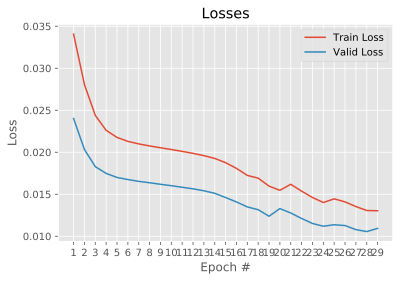

In [76]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [77]:
torch.save(model.state_dict(), 'model.pkl')

In [78]:
model = EncoderDecoder(
    input_char_set_size, 
    target_char_set_size, 
    hidden_size, 
    embedding_dim,
    1,
    targets_start_idx,
    targets_stop_idx,
).to(device)
model.load_state_dict(torch.load('model.pkl'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [79]:
model.eval()
total_loss = total = 0
with torch.no_grad():
    for inputs, targets, lengths in test_loader:
        print('>', ''.join([
            dataset.input_idx2char[idx]
            for idx in inputs.cpu()[0].numpy()[1:-1]
        ]))

        # Forwards pass
        outputs = model(inputs, targets, lengths, predict=True)
        print(''.join([
            dataset.target_idx2char[idx]
            for idx in outputs[:-1]
        ]))
        
        print()

> aik moh paints & chemicals pte ltd.
aik-certon.autoplic

> satya cashew chemicals pvt ltd.
satomic.pla.chahech

> johnson controls
qo.cononinon.contom

> dongguan goodjob precision components co.,ltd.
dost

> thinking space systems ltd.
thining.d.cksin.coa

> taiwan semiconductor co. ltd.
taiman1.eromasfodyl

> russian tank works
r-sst.comayaltfatac

> fonderia vs srl
frnder.com.cowirise

> unipal s.r.o.
uniprallailaupasik.

> engineered plastic products, inc.
jnsinemelorep.com

> dongguan lemo precision metal products co.,ltd
donguracongelys.com

> austal ships
austallal.coom

> anest iwata motherson pvt. ltd
anel.in

> hans peter schulte gmbh
honsnt.che

> abc compressors
abconipas.crlesestc

> shenzhen kingone technology co. ltd.
shem

> hanno-werk gmbh & co. kg
hanol-w.dom

> aludium
alufdemp-hum.com5m.

> demo audi
dlmomom

> hydrapower dynamics
hyd.com

> international contract molding, llc
ikn-rt.com

> jinan xiujian machine manufacturing co., ltd.
<SOS>itrnginca.darana.c

> f

venerl.ca.com

> schneeberger gmbh
schpen.dpberderneer

> prolead
prolubala.dlas-gadc

> ege forge
egegrom

> ningbo haina machine co. ltd.
nysgk.colinash.cran

> karad projects and motors limited
karadprobrtterlonde

> area9
areaatereyl.caupaea

> foundry & fabrication [totnes] limited
fom.corom

> marine and safety tasmania - mast
marine<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

> windus enterprises inc.
winduster.cecsian.c

> bird aerosystems ltda.
birpom

> rombis srl
aombus.comicomi.de

> national gummi ab
natato.com

> btb transfer spa
ftbrmanors.am

> china excellent source co.,limited
coininh.coesicom

> holtek semiconductor inc.
hrcke.cogom-k.col.c

> krohm stahl gmbh
krohmfntt.demat.hom

> gaylord packers pvt. ltd.
gadllcom

> suzhou labelong packaging machinery co.,ltd
sukmplcom

> alkin compressors inc
alkentpryspos.colis

> b&j international, llc
bgiv

> rosa experts ag & co kg
rosave

> sagam industries
saxam.usm

> pressmetall gunzenhausen gmbh
pr

trinitkuni.com.astt

> ningbo yinzhou zhenhua stamping co., ltd.
3ing-geom

> werksttten group
wer.com.ct.in.deste

> mdm cosmetic products gmbh & co. kg
mcom.cem

> scoutbee7
scoutebeneum

> taa connect
tasaroncon

> torun bakir alasimlari metal san ve tic as
tory-ky.cume.com.co

> hundt & weber gmbh
hunda-gde.ed.dutr.c

> koramex a.s.
koram.com

> bergstrom inc.
bergstomonro5rdrtro

> sag motion group alutech gmbh
sagro.astoviocotitr

> simai spa
sima4m

> bodo mller chemie gmbh
bodo-il.com

> gromet s.r.l.
grom.om.comtuet.cou

> joseph merritt group plc.
uestesteh.jichpr-n-

> jointus technology co.,ltd
eointonct

> taiwan kinki machinery co. ltd.
testhank.comieecinn

> scherdel gmbh
schewecom

> target hydrautech pvt. ltd.
targerom

> cnc machining parts cnc
cncnanm.ithi1<PAD><PAD><PAD><PAD><PAD><PAD>

> rsp inc
rbopinianst

> steel corp.
gsesellco.nere.com

> nordcontenitori sas
nordconetom

> blg international logistics gmbh
bl8-anshe

> struthers-dunn, llc
strg.ctrsdusco.c

> yo

sprecherechrebherhd

> lipp gmbh
lip.m

> huntingdon fusion techniques hft
hontianlinde

> sekisui s-lec b.v.
suknikishih.c.uim

> fostek corporation
fosteleinleksecolyt

> winters instruments
w<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

> alphanickel.com specialized in inc
alp0yanicom

> leybold optics usa inc.
leyyooomplup.coggol

> radix electrosystems pvt. ltd.
radicom.de-pect.cog

> bo-jiang technology co. ltd.
bomiavechng.com

> steel automotive gmbh
steea4.deuein.com

> aerostar aviation
aeromomom

> bebivita gmbh
bebg.ialitetane

> efs euro forming services gmbh
ffsasm

> metaldyne performance group, inc.
metaldyrvinter.cops

> vreugdenhil b.v.
vremg.deu8edndndech

> dongguan zhuowei (jowell) purification technology co., ltd.
dongruffail-ge

> laird technologies ltd.
lairdstcindendch.de

> trimlok inc.
trim

> hebei nanfeng metal products co.,ltd
hlbeianezem

> fremach gmbh
kremam

> kunshan variety plastic & hardware icp
kunshndo

comohy.ditin.conoma

> charkit chemical company
cscomtith.jfichertw

> casappa fluid power design
cysopafomepasaufaup

> stonkam co. ltd.
stonak<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

> fenghua refworld refrigeration industry co. ltd
fengwherawamomomb.d

> robotic automation p/l
robot.com

> smiths heiman
smithnsdhi<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

> beijing kaisheng'ao import and export co., ltd.
ueikin

> mosconi s.r.l.
mtsponionin.cos.ita

> hong kong hing fung industrial limited shenzhen xingfeng plastic co.,ltd
agngqcol.cool

> iberia maintenance mro company
ibera.cromanarin.co

> murray bridge flying school
muranarag.dracidict

> ap corporate and manufacturing.
a7chxcoratr-pre.ger

> buiced
bus.cecom

> h+h herrmann + hieber gmbh
hbhardman.comen.n.d

> atsa gold pty ltd
atom

> leman industrie romania
lemaus-m

> dell technologies
delaliteielethnoric

> r & w metal fabrication and design inc.
rzwematfafl.com

> stelco ltd.
stele

> unior ko